# Drone simulation

In this example, we generate IMU data from drone simulation logs.  We use the
[TartanAir V2](https://tartanair.org/) dataset.  The dataset contains trajectory
and sensor data from simulated drones operating in a large variety of
environments.

## Setup
Given its size and complexity, we do not re-host any of the data.  To download
the data directly, see the documentation at:
https://tartanair.org/examples.html#download-example.  The snippet below will
grab IMU data from a single environment.

!!! note "OS support"
    The code below was tested on `Ubuntu 20.04`.  It does not work on `macOS
    15.5`.  To run this example in other environments, copy the data manually to
    the `tartanair_data` directory.

In [ ]:
import tartanair as ta

# Initialize TartanAir
tartanair_data_root = "./tartanair_data"
ta.init(tartanair_data_root)

# Download IMU data from the Downtown environment
ta.download(env="Downtown", difficulty=["easy", "hard"], modality=["imu"], unzip=True)

## Specify a new IMU

We specify an [Epson
M-G370](https://global.epson.com/products_and_drivers/sensing_system/imu/) IMU
based on the manufacturer's data sheet.  The entire specification is shown here
but it is also included in the [devices][inertialsim.devices] library and can
simply be imported in future uses (`from inertialsim.devices.imu import
epson_mg370`).

!!! note "IMU Versions"
    There are multiple versions of the M-G370 IMU: `PDT`, `PDG`, `PDS`, and
    `PDF`, each with slightly differing specifications.  The spec. below is for
    the `PDT0` version as of June, 2025.

In [1]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# All rights reserved.
# Do not use or redistribute without permission.
# Email: info@inertialsim.com
# -----------------------------------------------------------------------------
from inertialsim.sensors import Parameter
from inertialsim.sensors.imu import IMUSpecification

# Notes:
# 1. Specified with 8g accelerometer range.
# 2. Specified with 16 bit data resolution.
# 3. Scale factor min/max approximated as normal 3-sigma

epson_mg370: IMUSpecification = IMUSpecification()
"""Specification for an Epson M-G370PDT IMU.

Reference: Brief Sheet, Rev. 1.1, 2022.08.  
Link: https://global.epson.com/products_and_drivers/sensing_system/imu/m-g370pdt.html
"""  # noqa: W291
epson_mg370.manufacturer = "Epson"
epson_mg370.model = "M-G370"
epson_mg370.version = "PDT0"

epson_mg370.data_interface.sample_rate = Parameter(100, "Hz")
epson_mg370.data_interface.quantization = (
    Parameter(1 / 150, "deg/s/LSB"),
    Parameter(1e-3 / 4, "g/LSB"),
)

epson_mg370.gyro.input_limits.minimum = Parameter(-200.0, "deg/s")
epson_mg370.gyro.input_limits.maximum = Parameter(200.0, "deg/s")
epson_mg370.gyro.noise.random_walk = Parameter(0.03, "deg/sqrt(h)")
epson_mg370.gyro.noise.bias_instability = Parameter(0.8, "deg/h")
epson_mg370.gyro.bias.repeatability = Parameter(36, "deg/h")
epson_mg370.gyro.scale_factor.repeatability = Parameter(0.2 / 3, "%")
epson_mg370.gyro.misalignment.repeatability = Parameter(0.01, "deg")

epson_mg370.accelerometer.input_limits.minimum = Parameter(-8.0, "g")
epson_mg370.accelerometer.input_limits.maximum = Parameter(8.0, "g")
epson_mg370.accelerometer.noise.random_walk = Parameter(0.02, "m/s/sqrt(h)")
epson_mg370.accelerometer.noise.bias_instability = Parameter(24e-6, "g")
epson_mg370.accelerometer.bias.repeatability = Parameter(2e-3, "g")
epson_mg370.accelerometer.scale_factor.repeatability = Parameter(0.1 / 3, "%")
epson_mg370.accelerometer.misalignment.repeatability = Parameter(0.01, "deg")


## Load the data

TartanAir provides advanced data loading tools.  See:
https://tartanair.org/examples.html#dataloader-example for an example.  Since we
are only working with IMU data, which are stored as [`.npy`
files](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html),
we provide a simple data loader that returns basic [dataclasses.dataclass][]
objects for IMU data and pose.

We convert them to timestamped [`Vector`][inertialsim.geometry.Vector] types
as the required 3-dimensional orthogonal input to the IMU simulation.

In [1]:
from inertialsim.examples import tartanair
from inertialsim.geometry import Vector
from inertialsim.devices.imu import epson_mg370
from inertialsim.sensors.imu import IMU, IMUModel

# Load trajectory #6 from Downtown environment in hard mode.
imu_data, pose_data = tartanair.load(
    directory="tartanair_data", environment="Downtown", difficulty="hard", trajectory=6
)

# Create ground truth 3-dimensional, orthogonal IMU input signals.
angular_rate = Vector.from_xyz(imu_data.angular_rate, imu_data.time)
specific_force = Vector.from_xyz(imu_data.specific_force, imu_data.time)


## Simulate the IMU measurement

Finally we specify the IMU and simulate the result.  The results are
[`Measurement`][inertialsim.sensors.Measurement] objects which do not
necessarily have orthogonal axes (due to sensor misalignment) and are not
necessarily 3-dimensional (however in this case, given the 3-axis Epson IMU,
they are).

In [2]:
# Create the IMU model.  By default we simulate everything except delta-angle,
# delta-velocity outputs which are not supported by the Epson IMU.  If we wanted
# to limit the simulation we would change the options here.
model = IMUModel()

# Create the simulated IMU.
imu = IMU(model=model, specification=epson_mg370, rng=1)

# Simulate the IMU response to the inputs.
result = imu.simulate(angular_rate=angular_rate, specific_force=specific_force)
gyro = result.angular_rate
accelerometer = result.specific_force

# We can also extract the internal state of the simulator (error terms, model
# settings, random number generator state, etc.) for reference.
gyro_state, accelerometer_state = imu.state

## Analyze results

These results represent a single sample of IMU measurements given the
specification and trajectory.  The specification includes both fixed
(deterministic) and random parameters.  The random specifications are assumed to
be 1-sigma statistics from a normal distribution (unless more information is
given by the manufacturer).  Each instance of `IMU()` and/or each call the
`simulate()` method will return fresh samples (subject to the `rng` input).

### Example fixed specifications

Below are examples of the fixed (deterministic) specification parameters.  They
do not change.

!!! note "Per-axis specifications"
    All specifications can be set and are applied on a per-axis basis.  The
    Epson M-G370 is a three-axis sensor and each axis has the same specification
    but this is not always the case for other devices.

In [3]:
import pprint

pprint.pprint("Gyro quantization (rad/s/LSB):")
pprint.pprint(gyro_state.sensor.data_interface.quantization)
print()
pprint.pprint("Accelerometer maximum input (m/s/s):")
pprint.pprint(accelerometer_state.sensor.input_limits.maximum)
print()
pprint.pprint("Gyro fixed bias (rad/s):")
pprint.pprint(gyro_state.sensor.bias.fixed)

'Gyro quantization (rad/s/LSB):'
array([[[0.00011636],
        [0.00011636],
        [0.00011636]]])

'Accelerometer maximum input (m/s/s):'
array([[[78.4532],
        [78.4532],
        [78.4532]]])

'Gyro fixed bias (rad/s):'
array([[[0.],
        [0.],
        [0.]]])


### Example random specifications

Below are examples of the random specification parameters.  They change with
each simulation.  In addition, some parameters apply for the entire duration of
the simulation (e.g. random scale factor), while others change at each sample
(e.g. random noise sources).

In [4]:
pprint.pprint("Gyro turn-on bias (rad/s):")
pprint.pprint(gyro_state.sensor.bias.random)
print()
pprint.pprint("Accelerometer misalignment (independent rotation per sensing axis):")
pprint.pprint(accelerometer_state.sensor.misalignment.random)


'Gyro turn-on bias (rad/s):'
array([[[5.13358050e-05],
        [4.96061692e-06],
        [9.54194168e-05]]])

'Accelerometer misalignment (independent rotation per sensing axis):'
array([[[ 9.99999993e-01,  7.20916831e-05, -9.12380038e-05],
        [-7.20946936e-05,  9.99999997e-01, -3.29927509e-05],
        [ 9.12356250e-05,  3.29993284e-05,  9.99999995e-01]],

       [[ 9.99999931e-01, -1.99761529e-04,  3.14065631e-04],
        [ 1.99627683e-04,  9.99999889e-01,  4.26147784e-04],
        [-3.14150724e-04, -4.26085058e-04,  9.99999860e-01]],

       [[ 9.99999990e-01, -4.90843560e-05,  1.35053333e-04],
        [ 4.90766853e-05,  9.99999997e-01,  5.68003137e-05],
        [-1.35056120e-04, -5.67936851e-05,  9.99999989e-01]]])


### Error plots

We plot the gyro and accelerometer errors which represent the non-linear
superposition of all error sources.  The gyro error shows a spike just after
`120s` where the `-200 deg/s` gyro input limits were reached.  

Accelerometer biases on the order of `2mg` (`0.02 m/s/s`) are clearly visible,
as expected.

Both error signals show frequency content consistent with the vehicle maneuvers
due to scale factor error on the order of `0.1%`.

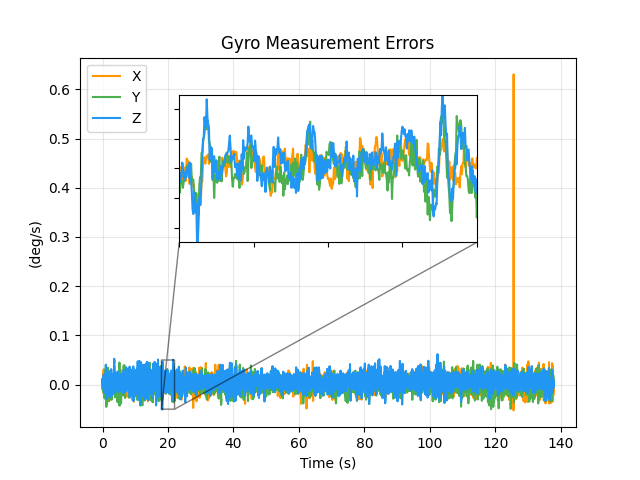

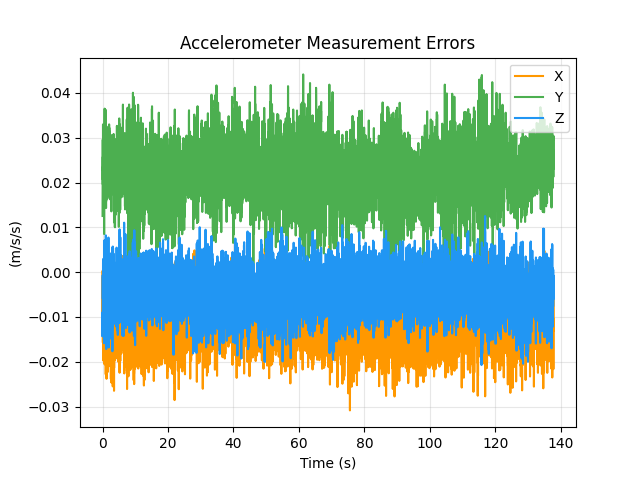

In [5]:
import numpy as np
from inertialsim import plot

%matplotlib widget

ar_plot = plot.TimeSeries(title="Gyro Measurement Errors", ylabel="(deg/s)")
ar_plot.line(
    gyro.time,
    np.rad2deg(gyro.data[:, :, 0] - imu_data.angular_rate),
)
ar_plot.legend(["X", "Y", "Z"])
ar_plot.zoom_inset([0.2, 0.5, 0.6, 0.4], [18, 22], [-0.05, 0.05])

sf_plot = plot.TimeSeries(title="Accelerometer Measurement Errors", ylabel="(m/s/s)")
sf_plot.line(
    accelerometer.time,
    accelerometer.data[:, :, 0] - imu_data.specific_force,
)
sf_plot.legend(["X", "Y", "Z"])


### Bias instability

Bias instability is a key performance parameter.  It is a noise source
characterized by a `1/f` (pink) frequency spectrum.  It represent a limit in the
precision of bias estimation that can be achieved by averaging alone.  Along
with other noise sources, it is generated for each output sample.  In this
simulation, the manufacturer only supplies two of five standard noise terms
(random walk and bias instability).  It is visualized below (converted to the
units used in the data sheet to ease comparison).

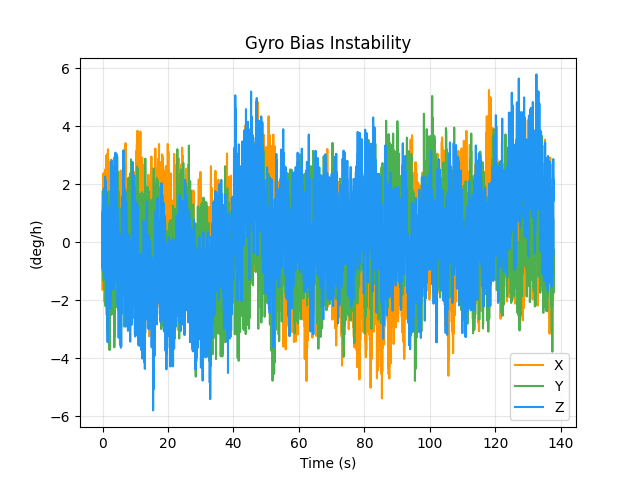

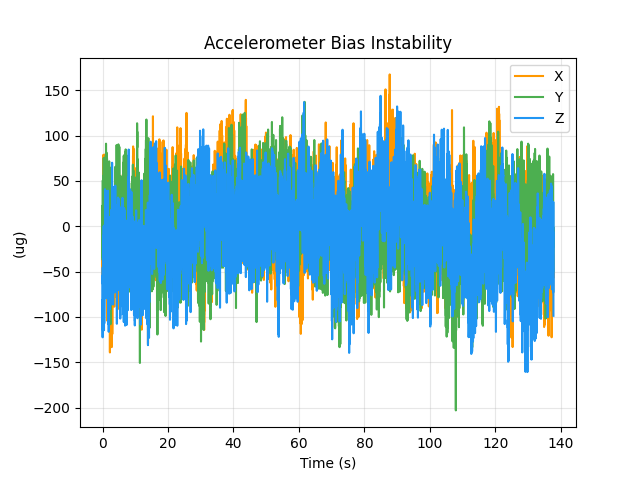

In [6]:
from inertialsim.geodesy import Gravity

ar_bias_drift = plot.TimeSeries(title="Gyro Bias Instability", ylabel="(deg/h)")
ar_bias_drift.line(
    gyro.time,
    np.rad2deg(gyro_state.sensor.noise.bias_instability) * 3600,
)
ar_bias_drift.legend(["X", "Y", "Z"])

sf_bias_drift = plot.TimeSeries(title="Accelerometer Bias Instability", ylabel="(ug)")
sf_bias_drift.line(
    accelerometer.time,
    1e6
    * accelerometer_state.sensor.noise.bias_instability
    / Gravity.standard_magnitude(),
)
sf_bias_drift.legend(["X", "Y", "Z"])

## Advanced Features

The examples above are a straightforward use of *InertialSim* given ground truth
angular rate and specific force inputs in a local Cartesian coordinate system.
*InertialSim* also supports simulating from pose inputs and using global
coordinates.  Those are demonstrated below for reference.

### Pose Inputs

To simulate from TartanAir pose data, we first load the ground truth pose data
into a geometric [`ExtendedPose`][inertialsim.geometry.ExtendedPose] class
(attitude, position, and velocity).  We then append it with the TartanAir
gravity model in a [`GlobalPose`][inertialsim.geodesy.GlobalPose] class.  The
angular rate and specific force data can then be queried directly from the
global pose object.

!!! note "Conventions"
    The TartanAir Euler angle and gravity conventions were reverse engineered
    from the source data.  *InertialSim* supports inputs using all common
    rotation and coordinate conventions.  It supports the `WGS84` ellipsoidal
    gravity model and custom user supplied gravity models.

In [ ]:
from inertialsim.geometry import ExtendedPose, Rotation
from inertialsim.geodesy import GlobalPose

# Create geometric extended pose.
attitude = Rotation.from_euler(
    pose_data.attitude[:, ::-1], sequence="ZYX", time=pose_data.time
)
local_pose = ExtendedPose.from_apv(attitude, pose_data.position, pose_data.velocity)

# Create a global pose object by defining gravity in addition to the geometric
# pose.  Earth rate is ignored because it varies by latitude and that remains
# unknown.
pose = GlobalPose.from_local(pose=local_pose, gravity=[0, 0, 9.8])

# Calculate sensor frame angular rate and specific force data.
pose.angular_rate()
pose.specific_force()


### Global Coordinates

The Epson IMU has a gyro bias repeatability of `36 deg/h`.  Earth rotates at
`~15 deg/h` (one rotation per day).  Ignoring Earth's rotation may therefore
introduce errors of the same order of magnitude as uncompensated gyro bias.

The accelerometer bias repeatability is `2mg`.  Gravity at Earth's surface
varies approximately `7mg` from its maximum (Arctic ocean) to its minimum
(Peru).  Approximating Earth's gravity as a constant `9.8 m/s/s` may therefore
introduce errors of the same order of magnitude as uncompensated accelerometer
bias.  A change in altitude of `6000 meters` reduces the magnitude of gravity by
approximately the same amount.  

Both sources of error can be compensated if the global pose of the IMU is
specified.  *InertialSim* accepts all common geodetic pose formats (latitude,
longitude, altitude, ECEF, etc.).  It also supports converting local Cartesian
pose to global pose if the origin and North alignment of the local coordinate
system is known.

In [ ]:
# Input pose in global coordinates and variation of gravity and Earth rate are
# modeled.
pose = GlobalPose.from_geodetic(...)
pose.angular_rate()
pose.specific_force()

# Better yet, input pose in local coordinates along with local coordinate
# origins and they are converted to global pose implicitly.
pose = GlobalPose.from_local(pose=local_pose, origin= ...,)
pose.angular_rate()
pose.specific_force()

### Magnetometer simulation

*InertialSim* also supports simulation of
[magnetometer][inertialsim.sensors.magnetometer] sensors using either a fixed
local magnetic field or the [World Magnetic
Model][inertialsim.geodesy.MagneticField].  Magnetometers are commonly used to
aid IMUs in AHRS and similar applications.